In [1]:
# %% [markdown]
# ### Imports

# %%
import pandas as pd
import numpy as np
from utility_functions import load_file, pickle_file, starting_run, finished_run
from analysis_variables import de_col_keys, de_col_values, demographic_tables, code_category_dict
from scipy.stats import f_oneway, ttest_ind, sem, norm, t
from statsmodels.stats.api import DescrStatsW, CompareMeans

full_dataset = load_file("summary_costs_enhanced.pickle")
filtered_dataset_codes = load_file("fully_filtered_codes.pickle")
comorbidities = load_file('comorbidities.pickle')

# %% [markdown]
# ### Demographic Column Classification

# %%
full_dataset["Married"] = full_dataset["marital_status"].eq('Married')
full_dataset["Uninsured"] = full_dataset["payer"].isin(['No charge', 'Self-pay'])
full_dataset["Medicare"] = full_dataset["payer"].eq('Medicare')
full_dataset["Medicaid"] = full_dataset["payer"].eq('Medicaid')
full_dataset["Private Insurance"] = full_dataset["payer"].eq('Private insurance')
full_dataset["White"] = full_dataset["race"].eq("White")
full_dataset["African American or Hispanic"] = full_dataset["race"].isin(['African-American', "Hispanic"])
full_dataset["Female"] = full_dataset["gender"].eq("Female")
full_dataset["Died"] = full_dataset["Died"].eq(1)

#rename some columns for cosmetic reasons:
full_dataset["Zip Code Income (mean quartile)"] = full_dataset["median_zip_income"]
full_dataset["Age (mean years)"] = full_dataset["age"]
full_dataset["Recurrent ED Visits (# / 1000 patients)"] = full_dataset["ED Readmissions"].mul(1000)
full_dataset["Repeat Hospitalizations (# / 1000 patients)"] = full_dataset["Inpatient Readmissions"].mul(1000)
full_dataset["Cost (USD)"] = full_dataset["Cost"]
full_dataset["Pediatric (<18)"] = full_dataset["Pediatric"]
full_dataset["Geriatric (>65)"] = full_dataset["Geriatric"]
full_dataset["Charleston Comorbidity Index (mean)"] = full_dataset["CMDF CCI"]
full_dataset["Length of Stay (mean days)"] = full_dataset["LOS"]
full_dataset["Deaths (%)"] = full_dataset["Died"]

# del full_dataset["Admitted"] #step needed in this analysis due to "Admitted" column in de_col_values
for key in de_col_keys:
    full_dataset = full_dataset.join([full_dataset[key].eq(val).rename(val).loc[full_dataset.index] for val in de_col_values[key]])
# full_dataset = full_dataset.join([full_dataset[de_col_name].eq(val).rename(val) for val in de_col_values])

dem_dataset = full_dataset[[
    'Zip Code Income (mean quartile)', 
    'Age (mean years)',
    "Pediatric (<18)",
    "Geriatric (>65)",
    'Cost (USD)',
    "Admitted",
    "Married",
    "Uninsured", 
    "Medicare",
    "Medicaid",
    "Private Insurance",
    "White",
    "African American or Hispanic",
    "Female",
    'Recurrent ED Visits (# / 1000 patients)',
    'Repeat Hospitalizations (# / 1000 patients)',
    'Deaths (%)',
    'Charleston Comorbidity Index (mean)',
    'Length of Stay (mean days)',
    *pd.core.common.flatten(de_col_values.values())
]].copy()

category_dict = {
    'Totals': 'Demographic',
    'Age (mean years)': 'Demographic',
    "Pediatric (<18)": 'Demographic',
    "Geriatric (>65)": 'Demographic',
    'White': 'Demographic',
    'African American or Hispanic': 'Demographic',
    'Female': 'Demographic',
    'Married': 'Demographic',
    'Medicaid': 'Insurance Status',
    'Medicare': 'Insurance Status',
    'Private Insurance': 'Insurance Status',
    'Uninsured': 'Insurance Status',
    'Zip Code Income (mean quartile)': 'Demographic',
    'Charleston Comorbidity Index (mean)': 'Comorbidity',
    **{key: 'Comorbidity' for key in pd.core.common.flatten(list(code_category_dict.keys())[20:])}, #first 20 used to calculate CCI
    'Recurrent ED Visits (# / 1000 patients)': 'Outcome',
    'Repeat Hospitalizations (# / 1000 patients)': 'Outcome',
    'Cost (USD)': 'Outcome',
    'Deaths (%)': 'Outcome',
    'Length of Stay (mean days)': 'Outcome',
    'Admitted': 'Clinical Pathway',
    **{value: 'Clinical Pathway' for value in pd.core.common.flatten(de_col_values.values())}
}

summary_table_sum_cols = [ #these are the columns that are not aggregates of proportions of patients
    "Cost (USD)", "Charleston Comorbidity Index (mean)", "Age (mean years)",
    "Zip Code Income (mean quartile)",'Length of Stay (mean days)',
    "Recurrent ED Visits (# / 1000 patients)",
    "Repeat Hospitalizations (# / 1000 patients)"
]

# %%
def create_outcome_crosscomparison_table(num_full_dataset, outcome_variable, groupby_row):
    table_data = {}
    if len(groupby_row) == 1: #This probably represents a demographic variable.
        groupby_row.append(f"Not {groupby_row[0]}")
        demographic_row = True
    else:
        demographic_row = False
    for name, dataset in num_full_dataset:
        if demographic_row:
            dataset[f"Not {groupby_row[0]}"] = (~(dataset[groupby_row[0]].astype("bool"))).astype(int) #need type conversions because NOT operation does not work on int series.
        dataset = dataset[[*groupby_row, outcome_variable]]
        table_data[f"{name} (%, 95% CI, N)"] = [dataset[dataset[row] == 1][outcome_variable] for row in groupby_row]
    dataset_df = pd.DataFrame(table_data, index=groupby_row)
    return_df = dataset_df.applymap(
        lambda cell: DescrStatsW(cell)
    ).applymap(
        lambda desc_stats: "{} ({} - {}), {}".format(
            round(desc_stats.mean,1),
            round(desc_stats.tconfint_mean(0.05)[0],1),
            round(desc_stats.tconfint_mean(0.05)[0],1),
            round(desc_stats.nobs,0)
        ) if desc_stats.nobs > 0 else " "
    )
    # doing statistics for both axes:
    for i in range(2):
        # Very similar logic to latter half of create_summary
        if len(dataset_df.columns) == 2:
            return_df["P-value (Welch's T-test)"] = dataset_df.agg(
                lambda row: round(ttest_ind(row[0], row[1], equal_var=False).pvalue, 5) \
                    if row[0].shape[0]*row[1].shape[0] > 0 else ' '
                , axis="columns" 
            ).apply(lambda p: "< 0.00001" if p == 0.0 else p)
        elif len(dataset_df.columns) > 2:
            return_df["P-value (ANOVA)"] = dataset_df.applymap(
                lambda cell: np.nan if len(cell) == 0 else cell
            ).agg(
                lambda row: round(f_oneway(*row.dropna()).pvalue, 5), axis="columns" 
            ).apply(lambda p: "< 0.00001" if p == 0.0 else p)
        dataset_df = dataset_df.T
        return_df = return_df.T
    return return_df.replace(np.nan, " ")

# %%
def create_summary(groupby_col, save_filepath, tb, filter_criteria="`Cost (USD)` >= 0"): #cost should always be positive, making this a universal filter
    #Dependencies for both cross-comparison and summary tables
    num_full_dataset = dem_dataset.query(filter_criteria).join(comorbidities, how="left")\
        .fillna(0).astype("int").join(full_dataset[groupby_col], rsuffix="r_").groupby(groupby_col)
    total_patients = num_full_dataset.count().T.iloc[0].sum()
    col_totals = num_full_dataset.count().T.iloc[0].apply(
        lambda total: f"{total} ({round(total/total_patients*100,1)}%)"
    )
    #Create summary tables
    agg_table = num_full_dataset.apply(lambda x: pd.Series(
        [DescrStatsW(x[column]) for column in x.columns],
        index=x.columns)).T.drop(groupby_col)
    summary_table = agg_table.transform(
        lambda row: [f"{round(val.mean, 1)} ({round(val.tconfint_mean(0.05)[0],1)}, {round(val.tconfint_mean(0.05)[1],1)})" for val in row] \
                    if row.name in summary_table_sum_cols else \
                    [f"{round(val.mean*100,1)}% ({round(val.tconfint_mean(0.05)[0]*100,1)}, {round(val.tconfint_mean(0.05)[1]*100,1)}), {round(val.sum, 1)}" for val in row],
        axis=1
    )
    summary_table.columns = [f"{col} (%, 95% CI, N)" for col in summary_table.columns]
    if(len(summary_table.columns) == 2):
        summary_table["Difference (95% CI)"] = agg_table.agg(
            lambda row: ("{} ({}, {})" if row.name in summary_table_sum_cols else "{}% ({}%, {}%)").format(
                *[
                    round(val * (1 if row.name in summary_table_sum_cols else 100), 1)\
                    for val in [row[0].mean-row[1].mean, *CompareMeans(row[0], row[1]).tconfint_diff(0.05, usevar='unequal')]
                ]
            ),
            axis=1
        )
        summary_table["P-value (Welch's T-test)"] = [
            round(ttest_ind(*[x for _, x in num_full_dataset[col]], equal_var=False).pvalue, 5) for col in agg_table.index
        ]
        summary_table["P-value (Welch's T-test)"] = summary_table["P-value (Welch's T-test)"].apply(
            lambda cell: "< 0.00001" if cell == 0.0 else cell
        )
        summary_table.loc["Totals"] = [*col_totals, ' ', ' ']
    elif len(summary_table.columns) > 2:
        summary_table["P-value (ANOVA)"] = [round(f_oneway(*[x for _, x in num_full_dataset[col]]).pvalue,5) for col in agg_table.index]
        summary_table["P-value (ANOVA)"] = summary_table["P-value (ANOVA)"].apply(
            lambda cell: "< 0.00001" if cell == 0.0 else cell
        )
        summary_table.loc["Totals"] = [*col_totals, ' ']
    else:
        summary_table.loc["Totals"] = col_totals
    summary_table.reindex(category_dict.keys()).to_csv(save_filepath)
    #Create cross-comparison tables
    if tb["has_outcome_crosscomparison"]:
        for table in tb["outcome_crosscomparison"]:
            create_outcome_crosscomparison_table(
                num_full_dataset,
                table["outcome_variable"],
                table["groupby_row"]
            ).to_csv(table["save_filepath"])

<AxesSubplot:ylabel='Proportion of ED Visits'>

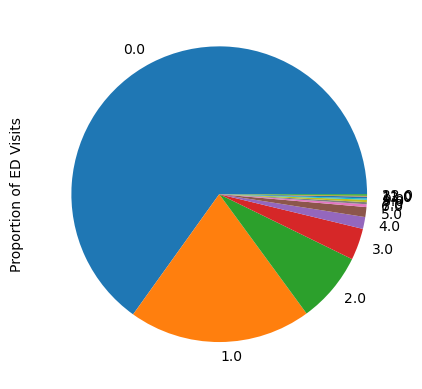

In [51]:
plot_data = full_dataset.loc[full_dataset["Concurrent Opioid Intoxication"]].loc[:, [
    "Cost (USD)", 'Length of Stay (mean days)',
    "Recurrent ED Visits (# / 1000 patients)",
    "Repeat Hospitalizations (# / 1000 patients)"
]]["Recurrent ED Visits (# / 1000 patients)"].div(1000).value_counts().reset_index()
plot_data["Proportion of ED Visits"] = plot_data["Recurrent ED Visits (# / 1000 patients)"].mul(plot_data["index"].add(1))
plot_data["Extra ED visits"] = plot_data["Recurrent ED Visits (# / 1000 patients)"].mul(plot_data["index"])
plot_data.set_index(["index"])["Proportion of ED Visits"].plot(kind="pie")

In [52]:
plot_data

,index,Recurrent ED Visits (# / 1000 patients),Proportion of ED Visits,Extra ED visits
0,0.0,9024,9024.0,0.0
1,1.0,1383,2766.0,1383.0
2,2.0,356,1068.0,712.0
3,3.0,120,480.0,360.0
4,4.0,36,180.0,144.0
5,5.0,25,150.0,125.0
6,6.0,6,42.0,36.0
7,7.0,4,32.0,28.0
8,8.0,4,36.0,32.0
9,9.0,2,20.0,18.0


In [53]:
plot_data["Extra ED visits"].agg("sum") / (9024 + plot_data["Extra ED visits"].agg("sum"))

0.24301652545927355

<AxesSubplot:ylabel='sum'>

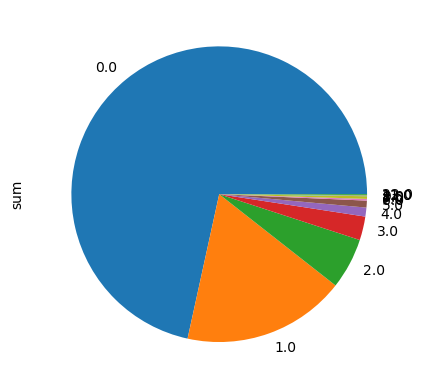

In [39]:
plot_data = full_dataset.loc[full_dataset["Concurrent Opioid Intoxication"]].loc[:, [
    "Cost (USD)", 'Length of Stay (mean days)',
    "Recurrent ED Visits (# / 1000 patients)",
    "Repeat Hospitalizations (# / 1000 patients)"
]].groupby(["Recurrent ED Visits (# / 1000 patients)"])["Cost (USD)"].agg(["sum", "count", "mean"]).reset_index()
plot_data["Recurrent ED Visits (# / 1000 patients)"] = plot_data["Recurrent ED Visits (# / 1000 patients)"].div(1000)
plot_data.set_index("Recurrent ED Visits (# / 1000 patients)")["sum"].plot(kind="pie")

In [40]:
cost_data = (plot_data.set_index("Recurrent ED Visits (# / 1000 patients)")["sum"].iloc[0])
cost_data_revisits = (plot_data.set_index("Recurrent ED Visits (# / 1000 patients)")["sum"].iloc[1:].agg(sum))

In [41]:
cost_data_revisits/(cost_data_revisits + cost_data)

0.28435083793666555

In [43]:
plot_data.set_index("Recurrent ED Visits (# / 1000 patients)")["mean"].iloc[0]

2236.700076763736

In [46]:
(plot_data.set_index("Recurrent ED Visits (# / 1000 patients)")["mean"].iloc[1:].agg("mean"))

8904.603870688015